In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class SMAOptimizer:
    def __init__(self, symbol, start, end, commission=0.0005): # 0.05% costo (Quantfury realístico)
        self.symbol = symbol
        self.start = start
        self.end = end
        self.commission = commission
        self.data = None
        self.results_table = [] # Aquí guardaremos cada prueba

    def get_data(self):
        """Descarga una sola vez para no spammear a Yahoo"""
        raw = yf.download(self.symbol, start=self.start, end=self.end, auto_adjust=True, progress=False)
        data = pd.DataFrame()
        data['price'] = raw['Close']
        data['returns'] = np.log(data['price'] / data['price'].shift(1))
        self.data = data
        print(f"Data cargada. Iniciando optimización...")

    def optimize(self, min_window=10, max_window=200, step=2):
        if self.data is None: self.get_data()

        # Iteramos por todas las ventanas (10, 12, 14 ... 200)
        windows = range(min_window, max_window + 1, step)
        total_trials = len(windows)

        print(f"Probando {total_trials} estrategias distintas...")

        for w in windows:
            df = self.data.copy()

            # Lógica Rápida
            df['sma'] = df['price'].rolling(w).mean()
            df['position'] = np.where(df['price'] > df['sma'], 1, 0)

            # Costos y Retornos
            trades = df['position'].diff().fillna(0).abs()
            gross_returns = df['position'].shift(1) * df['returns']
            net_returns = gross_returns - (trades * self.commission)

            df.dropna(inplace=True)

            # Calcular Sharpe Rápido para esta ventana 'w'
            if len(net_returns) > 100: # Solo si hay suficientes datos
                mean_ret = net_returns.mean() * 252
                vol = net_returns.std() * np.sqrt(252)
                sharpe = mean_ret / vol if vol > 0 else 0

                # Guardamos el resultado
                self.results_table.append({
                    'SMA_Window': w,
                    'Sharpe_Ratio': sharpe,
                    'Annual_Return': mean_ret
                })

        # Convertimos a DataFrame para analizar
        self.results_df = pd.DataFrame(self.results_table)
        self.total_trials = total_trials # Guardamos N para el DSR

    def plot_optimization_landscape(self):
        if not self.results_table: return

        # 1. Encontrar la mejor
        best_row = self.results_df.loc[self.results_df['Sharpe_Ratio'].idxmax()]
        best_window = int(best_row['SMA_Window'])
        best_sharpe = best_row['Sharpe_Ratio']

        # 2. Calcular DSR riguroso con el N total
        # Asumiendo benchmark 0 para simplificar el cálculo visual
        # E[Max Sharpe] aprox sqrt(2 * ln(N))
        expected_max_sharpe = np.sqrt(2 * np.log(self.total_trials))
        dsr_score = (best_sharpe - expected_max_sharpe) # Simplificado, si es positivo es bueno

        print(f"\n--- GANADOR DE LA OPTIMIZACIÓN ---")
        print(f"Mejor Ventana SMA: {best_window}")
        print(f"Mejor Sharpe Ratio: {best_sharpe:.4f}")
        print(f"Pruebas Totales (N): {self.total_trials}")
        print(f"Sharpe Mínimo Requerido por DSR (aprox): {expected_max_sharpe:.4f}")

        if best_sharpe > expected_max_sharpe:
            print("✅ RESULTADO: El Sharpe SUPERA la barrera del ruido (DSR Probable > 50%)")
        else:
            print("⚠️ RESULTADO: El Sharpe NO supera la barrera estadística (Posible Overfitting)")

        # 3. Gráfico de "Montaña" (Landscape)
        plt.figure(figsize=(14, 6))

        # Coloreamos según el Sharpe (Mapa de calor en barra)
        plt.bar(self.results_df['SMA_Window'], self.results_df['Sharpe_Ratio'],
                width=1.5, color='orange', alpha=0.7, label='Performance')

        # Destacar el Ganador
        plt.axvline(best_window, color='green', linestyle='--', label=f'Óptimo (SMA {best_window})')

        # Línea de Sharpe Cero
        plt.axhline(0, color='black', linewidth=1)

        plt.title(f"Espacio de Búsqueda: Sensibilidad de SMA (Costo 0.05%)")
        plt.xlabel("Periodo de la Media Móvil (Días)")
        plt.ylabel("Sharpe Ratio (Riesgo/Beneficio)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

Data cargada. Iniciando optimización...
Probando 96 estrategias distintas...

--- GANADOR DE LA OPTIMIZACIÓN ---
Mejor Ventana SMA: 124
Mejor Sharpe Ratio: 0.9824
Pruebas Totales (N): 96
Sharpe Mínimo Requerido por DSR (aprox): 3.0214
⚠️ RESULTADO: El Sharpe NO supera la barrera estadística (Posible Overfitting)


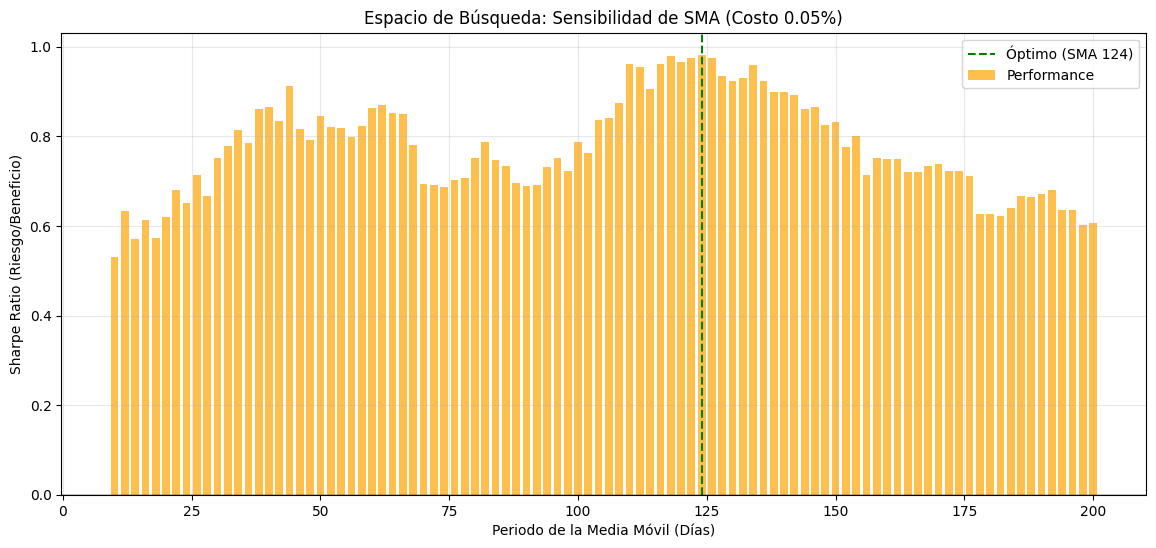

In [3]:
optimizer = SMAOptimizer("BTC-USD", "2018-01-01", "2024-01-01", commission=0.0005) # 0.05%
optimizer.optimize(min_window=10, max_window=200, step=2) # Probamos de 2 en 2
optimizer.plot_optimization_landscape()

Descargando data con buffer desde 2023-04-07...

--- REPORTE COMPARATIVO COMPLETO (OOS: 2024-02-01 - 2025-11-20) ---
MÉTRICA              | ESTRATEGIA (SMA)   | MERCADO (BTC)     
-----------------------------------------------------------------
Retorno Anual        |            28.00% |            29.28%
Volatilidad          |            31.77% |            39.94%
Sharpe Ratio         |           0.7341  |           0.6159 
Max Drawdown         |           -25.38% |           -28.14%
VaR (95%)            |            -3.00% |            -3.81%
CVaR (95%)           |            -4.57% |            -5.41%
STARR Ratio          |           0.3215  |           0.2866 
-----------------------------------------------------------------
PSR Estrategia (Prob > 0): 1.0000
-----------------------------------------------------------------
🛡️ SEGURIDAD: La Estrategia reduce significativamente el riesgo de colapso (Mejor CVaR).


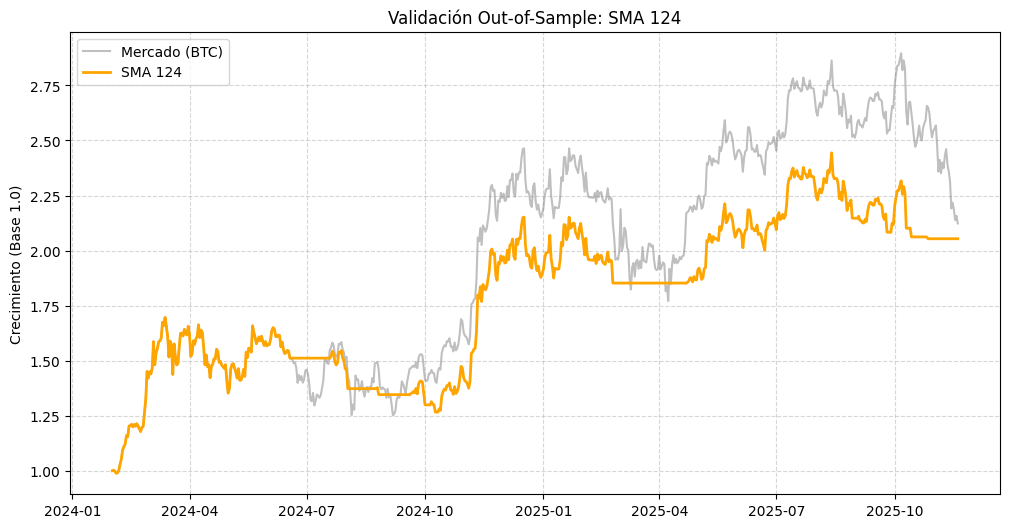

In [4]:
class OutOfSampleTester:
    def __init__(self, symbol, test_start, test_end, sma_window):
        self.symbol = symbol
        self.test_start = pd.to_datetime(test_start)
        self.test_end = pd.to_datetime(test_end)
        self.sma_window = sma_window
        self.results = None
        self.data = None

    def get_data(self):
        # Buffer de 300 días para calentar indicadores
        buffer_date = self.test_start - pd.Timedelta(days=300)
        print(f"Descargando data con buffer desde {buffer_date.date()}...")

        raw = yf.download(self.symbol, start=buffer_date, end=self.test_end, auto_adjust=True, progress=False)

        # Parche para yfinance 0.2.40+ (MultiIndex fix)
        if isinstance(raw.columns, pd.MultiIndex):
            raw.columns = raw.columns.get_level_values(0)

        data = pd.DataFrame()
        data['price'] = raw['Close']
        data['returns'] = np.log(data['price'] / data['price'].shift(1))
        self.data = data

    def run_validation(self, commission=0.0005):
        if self.data is None: self.get_data()
        data = self.data.copy()

        # 1. Estrategia SMA
        data['sma'] = data['price'].rolling(self.sma_window).mean()
        data['position'] = np.where(data['price'] > data['sma'], 1, 0)

        # 2. Retornos Netos
        trades = data['position'].diff().fillna(0).abs()
        gross = data['position'].shift(1) * data['returns']
        data['net_returns'] = gross - (trades * commission)

        # 3. FILTRADO (Out of Sample Puro)
        test_data = data.loc[data.index >= self.test_start].copy()

        # Re-base a 1.0
        test_data['creturns_market'] = np.exp(test_data['returns'].cumsum())
        test_data['creturns_strategy'] = np.exp(test_data['net_returns'].cumsum())

        # Normalizar al inicio
        test_data['creturns_market'] /= test_data['creturns_market'].iloc[0]
        test_data['creturns_strategy'] /= test_data['creturns_strategy'].iloc[0]

        self.results = test_data

    def _calculate_metrics(self, returns_series, risk_free=0.0468):
        """Función auxiliar para calcular métricas de cualquier serie"""
        # Estadísticas básicas
        mean = returns_series.mean() * 252
        vol = returns_series.std() * np.sqrt(252)
        sharpe = (mean - risk_free) / vol if vol > 0 else 0

        # Drawdown
        cum_rets = np.exp(returns_series.cumsum())
        peak = cum_rets.cummax()
        drawdown = (cum_rets - peak) / peak
        max_dd = drawdown.min()

        return {
            'Retorno Anual': mean,
            'Volatilidad': vol,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_dd
        }

    def get_thesis_metrics(self, risk_free_annual=0.0468):
        if self.results is None: return

        # Función interna para calcular métricas de riesgo avanzadas
        def calc_advanced_metrics(series, rf=0.0468):
            # Básicas
            mean = series.mean() * 252
            vol = series.std() * np.sqrt(252)
            sharpe = (mean - rf) / vol if vol > 0 else 0

            # Drawdown
            cum_rets = np.exp(series.cumsum())
            peak = cum_rets.cummax()
            drawdown = (cum_rets - peak) / peak
            max_dd = drawdown.min()

            # Riesgo de Cola (VaR/CVaR)
            cutoff = (1 - 0.95) * 100
            var_95 = np.percentile(series, cutoff)
            cvar_95 = series[series <= var_95].mean()

            # STARR
            cvar_ann = cvar_95 * np.sqrt(252)
            starr = (mean - rf) / abs(cvar_ann) if cvar_ann != 0 else 0

            return {
                'Retorno Anual': mean,
                'Volatilidad': vol,
                'Sharpe Ratio': sharpe,
                'Max Drawdown': max_dd,
                'VaR (95%)': var_95,
                'CVaR (95%)': cvar_95,
                'STARR Ratio': starr
            }

        # 1. Calcular para AMBOS
        stats_strat = calc_advanced_metrics(self.results['net_returns'], risk_free_annual)
        stats_market = calc_advanced_metrics(self.results['returns'], risk_free_annual)

        # 2. PSR (Solo aplica a estrategia activa vs benchmark 0)
        rets_strat = self.results['net_returns']
        skew = stats.skew(rets_strat)
        kurt = stats.kurtosis(rets_strat)
        n = len(rets_strat)
        sharpe_std = np.sqrt((1 + (0.5 * skew**2) - ((skew * kurt) / 4)) / (n - 1))
        psr = stats.norm.cdf((stats_strat['Sharpe Ratio'] - 0) / sharpe_std)

        # 3. IMPRIMIR REPORTE FINAL
        print(f"\n--- REPORTE COMPARATIVO COMPLETO (OOS: {self.test_start.date()} - {self.test_end.date()}) ---")
        print(f"{'MÉTRICA':<20} | {'ESTRATEGIA (SMA)':<18} | {'MERCADO (BTC)':<18}")
        print("-" * 65)

        metrics_list = [
            ('Retorno Anual', True),
            ('Volatilidad', True),
            ('Sharpe Ratio', False),
            ('Max Drawdown', True),
            ('VaR (95%)', True),
            ('CVaR (95%)', True),
            ('STARR Ratio', False)
        ]

        for name, is_pct in metrics_list:
            val_s = stats_strat[name]
            val_m = stats_market[name]

            if is_pct:
                print(f"{name:<20} | {val_s*100:16.2f}% | {val_m*100:16.2f}%")
            else:
                print(f"{name:<20} | {val_s:16.4f}  | {val_m:16.4f} ")

        print("-" * 65)
        print(f"PSR Estrategia (Prob > 0): {psr:.4f}")
        print("-" * 65)

        # Veredicto de Riesgo de Cola
        if stats_strat['CVaR (95%)'] > stats_market['CVaR (95%)']: # Mayor es mejor porque son negativos (ej: -4% > -6%)
            print("🛡️ SEGURIDAD: La Estrategia reduce significativamente el riesgo de colapso (Mejor CVaR).")
        else:
            print("⚠️ RIESGO: La Estrategia es igual o más peligrosa que el Mercado en días malos.")


    def plot_results(self):
        if self.results is None: return

        plt.figure(figsize=(12, 6))
        plt.plot(self.results['creturns_market'], label='Mercado (BTC)', alpha=0.5, color='gray')
        plt.plot(self.results['creturns_strategy'], label=f'SMA {self.sma_window}', linewidth=2, color='orange')

        plt.title(f"Validación Out-of-Sample: SMA {self.sma_window}")
        plt.ylabel("Crecimiento (Base 1.0)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

# --- EJECUCIÓN ---
oos = OutOfSampleTester("BTC-USD", "2024-02-01", "2025-11-20", 124)
oos.run_validation(commission=0.0005)
oos.get_thesis_metrics(risk_free_annual=0.0468)
oos.plot_results()

In [5]:
def plot_rolling_health(results_df, window=90):
    """
    results_df: Tu DataFrame con los resultados OOS (strategy_returns)
    window: Ventana de evaluación (ej: 3 meses / 90 días)
    """
    df = results_df.copy()

    # Calculamos Sharpe Ratio móvil (ventana de 3 meses)
    # Mean / Std * Raíz(252)
    rolling_mean = df['net_returns'].rolling(window).mean()
    rolling_std = df['net_returns'].rolling(window).std()

    # Evitar división por cero
    rolling_sharpe = (rolling_mean / rolling_std * np.sqrt(252)).fillna(0)

    # GRAFICAR
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # 1. Curva de Capital (Tu riqueza)
    ax1.plot(df['creturns_strategy'], label='Estrategia SMA', color='orange')
    ax1.plot(df['creturns_market'], label='Mercado BTC', color='blue', alpha=0.3)
    ax1.set_title("1. Desempeño Acumulado")
    ax1.grid(True, linestyle='--')
    ax1.legend()

    # 2. Monitor de Salud (Rolling Sharpe)
    ax2.plot(rolling_sharpe, label=f'Sharpe Rodante ({window} días)', color='purple')

    # Zonas de Semáforo
    ax2.axhline(1.0, color='green', linestyle='--', label='Saludable (>1)')
    ax2.axhline(0.5, color='orange', linestyle='--', label='Decay/Alerta (<1)')
    ax2.axhline(0.0, color='red', linestyle='-', linewidth=2, label='Falla Crítica (<0)')

    # Relleno visual
    ax2.fill_between(df.index, rolling_sharpe, 0, where=(rolling_sharpe < 0), color='red', alpha=0.1)
    ax2.fill_between(df.index, rolling_sharpe, 1, where=(rolling_sharpe > 1), color='green', alpha=0.1)

    ax2.set_title("2. Monitor de Salud (¿Cuándo muere la estrategia?)")
    ax2.set_ylabel("Sharpe Ratio")
    ax2.grid(True)
    ax2.legend()

    plt.show()

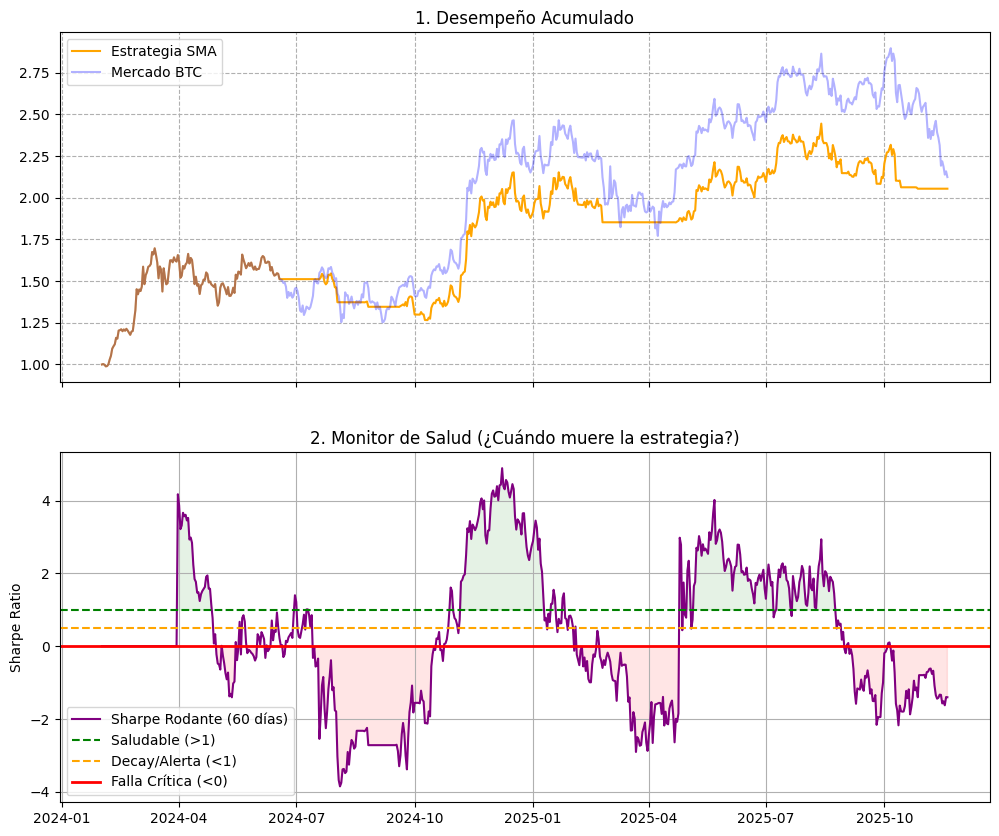

In [6]:
# --- EJECUCIÓN (Usando tu objeto oos_tester anterior) ---
# Asegúrate de haber corrido oos_tester.run_validation() antes
plot_rolling_health(oos.results, window=60)